# IMDB 50K Movie Reviews Sentiment Classification with XGBoost and Comparative Analysis

**Muhammad Ahmad**

## 1. **Setup and Data Loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline

# Uncomment this if stopwords and wordnet are not downloaded
#nltk.download('stopwords')
#nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load
df = pd.read_csv('MDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2. **Exploratory Data Analysis (EDA)**


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
print("Shape:", df.shape)
print("\nSentiment distribution:\n", df['sentiment'].value_counts())

Shape: (50000, 2)

Sentiment distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


**Statistics of reviews length**

In [5]:
df['length'] = df['review'].str.len()

length_stats = df['length'].describe()
print(length_stats)

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: length, dtype: float64


**Shortest and longest reviews**

In [6]:
short = df.loc[df['length'].idxmin(), 'review']
long  = df.loc[df['length'].idxmax(), 'review']
print("Shortest review:\n", short, "…\n")
print("Longest review:\n", long[:200], "…")

Shortest review:
 Read the book, forget the movie! …

Longest review:
 Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris B …


**Positive VS Negative Reviews**

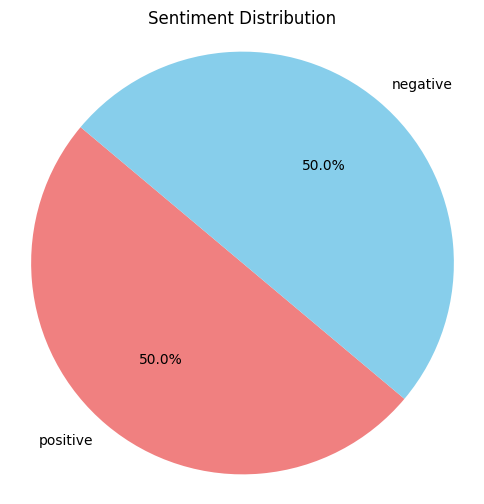

In [7]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'skyblue'], startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()


In [8]:
df.groupby('sentiment').describe()

length                                                        \
             count        mean          std   min    25%    50%      75%   
sentiment                                                                  
negative   25000.0  1294.06436   945.892669  32.0  706.0  973.0  1567.25   
positive   25000.0  1324.79768  1031.492627  65.0  691.0  968.0  1614.00   

                    
               max  
sentiment           
negative    8969.0  
positive   13704.0

**Distribution of Reviews Length**

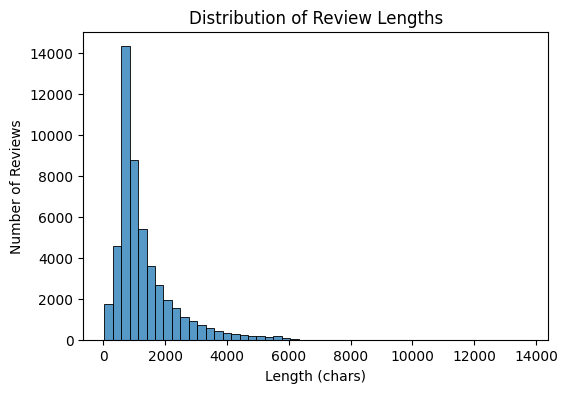

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(df['length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length (chars)')
plt.ylabel('Number of Reviews')
plt.show()

**Average Length by Sentiment**

sentiment
negative    1294.06436
positive    1324.79768
Name: length, dtype: float64 



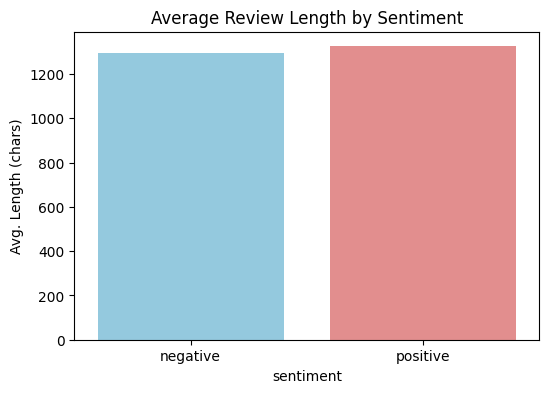

In [10]:
avg_len = df.groupby('sentiment')['length'].mean()
print(avg_len, "\n")

plt.figure(figsize=(6,4))
sns.barplot(x=avg_len.index, y=avg_len.values, palette=['skyblue', 'lightcoral'])
plt.title('Average Review Length by Sentiment')
plt.ylabel('Avg. Length (chars)')
plt.show()

**BoxPlot of Review Length by Sentiment**

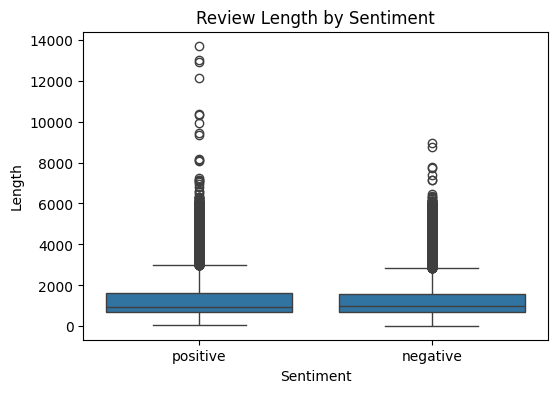

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='length', data=df)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Length')
plt.show()

## 3. **Text Preprocessing**

**Convert to Lowercase + Remove HTML tags, punctuation, stopwords, Multiple Spaces, Integers and Single Characters**

In [12]:
stop_words = set(stopwords.words('english'))
def clean_text(x):
    x = re.sub(r'<.*?>','', x)  # Remove HTML tags
    
    x = re.sub('\W',' ', x)  # Remove Punctuations 
    x = re.sub('\s+[a-zA-Z]\s+',' ', x)  # Removing single characters
    x = re.sub('\s+',' ', x) # Substituting multiple spaces with single space
    x = re.sub('\d','', x)  # Remove integers
    x = x.lower()   # Convert to lower Case
    
    tokens = x.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

print("Stop Words to be Removed: \n", stop_words)
print("\nPunctuations to be Removed: ", string.punctuation)

Stop Words to be Removed: 
 {'you', 'each', 'i', 'about', 'has', 'hadn', "haven't", "shan't", "she'd", 'their', 'from', "we'll", 'other', 'are', "wasn't", 'both', "couldn't", 'which', "he'd", 'for', 'he', 'once', 'an', 'shouldn', 'against', 'than', "shouldn't", 'mustn', 'at', "it'll", 'with', "wouldn't", "i'm", 'after', 'had', 'ma', 'your', 'same', 'they', 'shan', "didn't", "we're", 'him', 'and', "it's", 'that', 'were', 'been', 've', 'where', 'hers', 'does', 'but', "he'll", 'most', "mustn't", 'nor', 'mightn', 'm', 'needn', 'then', 'not', 'yours', 'themselves', 'all', 'as', 'couldn', 'our', "don't", 'yourself', 'she', 'who', 'no', 'himself', 'more', 's', 'o', 'won', 'into', 'haven', 'it', 'again', 'hasn', 'herself', 'me', 'ours', 'his', 're', 'am', "isn't", 'until', 'down', "they've", 'my', 'yourselves', 'd', 'own', "we'd", 'should', 'some', 'only', 'below', 'because', "we've", "doesn't", 'those', 'her', 'aren', "he's", "aren't", 'very', "you've", 'while', 'be', 'over', "she's", "they'l

In [13]:
print("Review Sample Before Cleaning Noisy Data:")
df['review'][17]

Review Sample Before Cleaning Noisy Data:


"This movie made it into one of my top 10 most awful movies. Horrible. <br /><br />There wasn't a continuous minute where there wasn't a fight with one monster or another. There was no chance for any character development, they were too busy running from one sword fight to another. I had no emotional attachment (except to the big bad machine that wanted to destroy them) <br /><br />Scenes were blatantly stolen from other movies, LOTR, Star Wars and Matrix. <br /><br />Examples<br /><br />>The ghost scene at the end was stolen from the final scene of the old Star Wars with Yoda, Obee One and Vader. <br /><br />>The spider machine in the beginning was exactly like Frodo being attacked by the spider in Return of the Kings. (Elijah Wood is the victim in both films) and wait......it hypnotizes (stings) its victim and wraps them up.....uh hello????<br /><br />>And the whole machine vs. humans theme WAS the Matrix..or Terminator.....<br /><br />There are more examples but why waste the time? 

In [14]:
df['clean_review'] = df['review'].apply(clean_text)

In [15]:
print("Review Sample After Cleaning Noisy Data:")
df['clean_review'][17]

Review Sample After Cleaning Noisy Data:


'movie made one top awful movies horrible continuous minute fight one monster another chance character development busy running one sword fight another emotional attachment except big bad machine wanted destroy scenes blatantly stolen movies lotr star wars matrix examples ghost scene end stolen final scene old star wars yoda obee one vader spider machine beginning exactly like frodo attacked spider return kings elijah wood victim films wait hypnotizes stings victim wraps uh hello whole machine vs humans theme matrix terminator examples waste time someone tell nazi nazi juvenile story line rushed juvenile conclusion movie could decide children movie adult movie much either awful real disappointment say least save money'

In [16]:
df[['review','clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


**Applying Lemmatization to reduce a word to its root form called a lemma**

In [17]:
def lemma_words(x):
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = x.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [18]:
df['clean_review'] = df['clean_review'].apply(lemma_words)

In [19]:
print("After Lemmatization: ")
df['clean_review'][17]

After Lemmatization: 


'movie made one top awful movie horrible continuous minute fight one monster another chance character development busy running one sword fight another emotional attachment except big bad machine wanted destroy scene blatantly stolen movie lotr star war matrix example ghost scene end stolen final scene old star war yoda obee one vader spider machine beginning exactly like frodo attacked spider return king elijah wood victim film wait hypnotizes sting victim wrap uh hello whole machine v human theme matrix terminator example waste time someone tell nazi nazi juvenile story line rushed juvenile conclusion movie could decide child movie adult movie much either awful real disappointment say least save money'

**Using Label Encoder to Convert Postive and Negative into 0 and 1**

In [20]:
df['sentiment'] = LabelEncoder().fit_transform(df['sentiment'])
df.head()

,review,sentiment,length,clean_review
0,One of the other reviewers has mentioned that ...,1,1761,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,1,998,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,926,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,748,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317,petter mattei love time money visually stunnin...


**WordCloud of Positive Reviews**

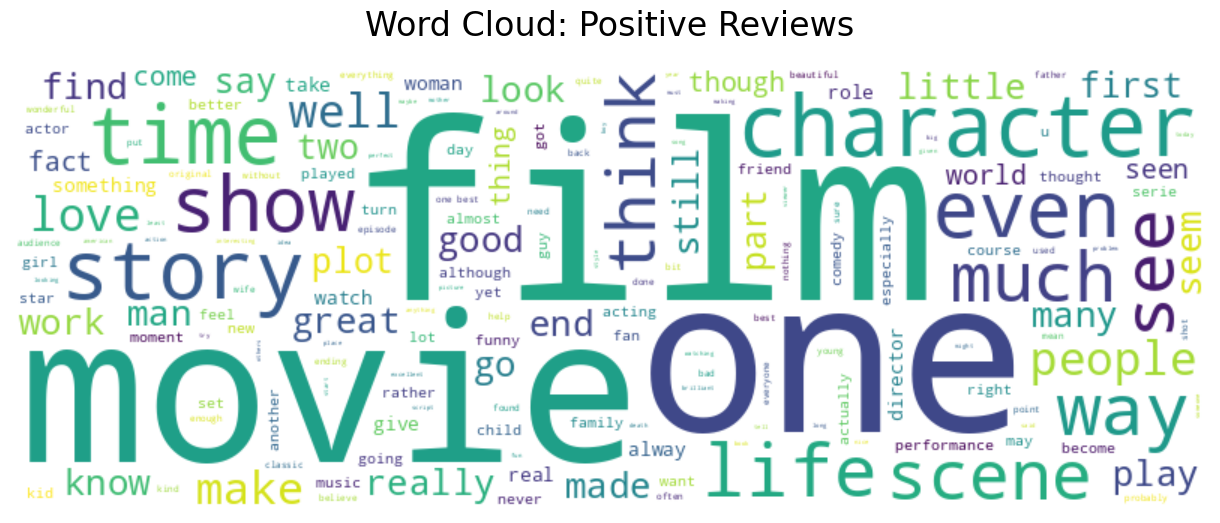

In [21]:
text_pos = " ".join(df[df['sentiment'] == 1]['clean_review'])

wc_pos = WordCloud(
    width=800,
    height=300,
    max_words=170,
    background_color='white',
    colormap='viridis',
    margin=10,
    random_state=42
).generate(text_pos)

# Plot
plt.figure(figsize=(12, 8), facecolor='white')
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud: Positive Reviews', fontsize=24, color='black', pad=20)
plt.show()

**WordCloud of Negative Reviews**

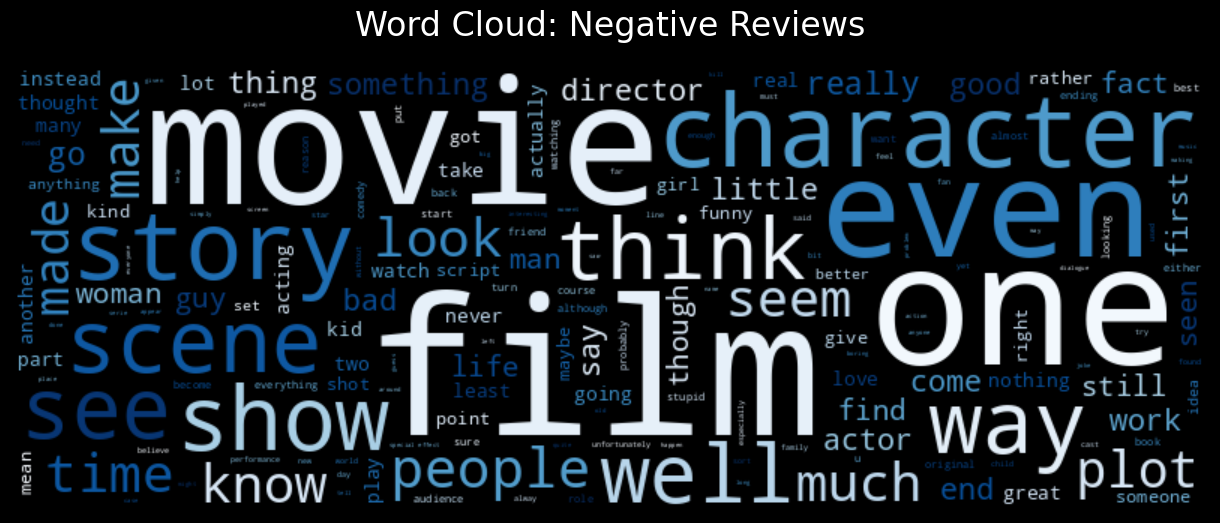

In [22]:
text_neg = " ".join(df[df['sentiment'] == 0]['clean_review'])

wc_neg = WordCloud(
    width=800,
    height=300,
    max_words=170,
    background_color='black',
    colormap='Blues',
    margin=10,
    random_state=42,
).generate(text_neg)

# Plot
plt.figure(figsize=(12, 8), facecolor='black')
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud: Negative Reviews', fontsize=24, color='white', pad=20)
plt.show()


## 4. Feature Extraction (TF‑IDF)

Term Frequency-Inverse Document Frequency

TF-IDF(t, d, D) = TF(t, d) * IDF(t, D), where: 
t is the term, 
d is the document, 
D is the corpus.

<img src="https://miro.medium.com/v2/resize:fit:1200/1*V9ac4hLVyms79jl65Ym_Bw.jpeg" width="500" height="340">

In [23]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,2))
x = tfidf.fit_transform(df['clean_review'])
y = df['sentiment']

## 5. Model Training with XGBoost


In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2,random_state=42)

In [25]:
model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.3,
    random_state=42
)
model = XGBClassifier()

In [26]:
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## 6. **Evaluation & Interpretation**


In [27]:
predictions = model.predict(xtest)
print("\nClassification Report:")
print(classification_report(ytest, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4961
           1       0.85      0.88      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



**Confusion Matrix**

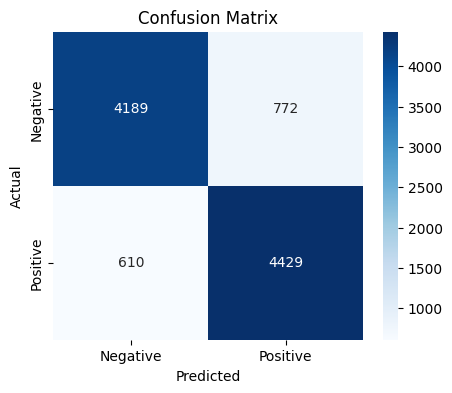

In [28]:
cm = confusion_matrix(ytest, predictions)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**ROC Curve & AUC**

The ROC curve (Receiver Operating Characteristic curve) is a graphical representation of a binary classifier's performance at various threshold settings. The AUC (Area Under the Curve) is a scalar value that summarizes the ROC curve, representing the probability that the model will correctly rank a randomly chosen positive instance higher than a randomly chosen negative one.
TPR: (also known as sensitivity or recall) is the proportion of actual positives that are correctly identified. 
FPR: is the proportion of actual negatives that are incorrectly identified as positives. 

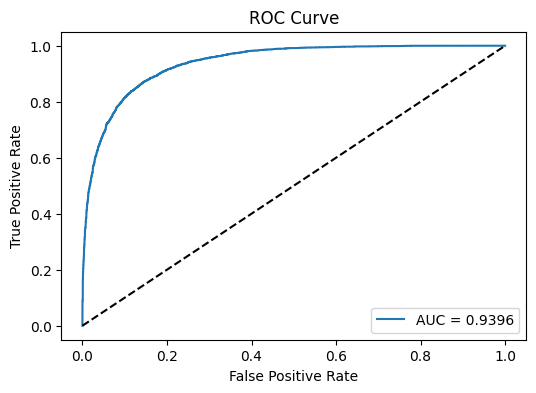

In [29]:
y_probs = model.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, y_probs)
xgb_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {xgb_roc_auc:.4f}')
plt.plot([0,1],[0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Feature Importance**

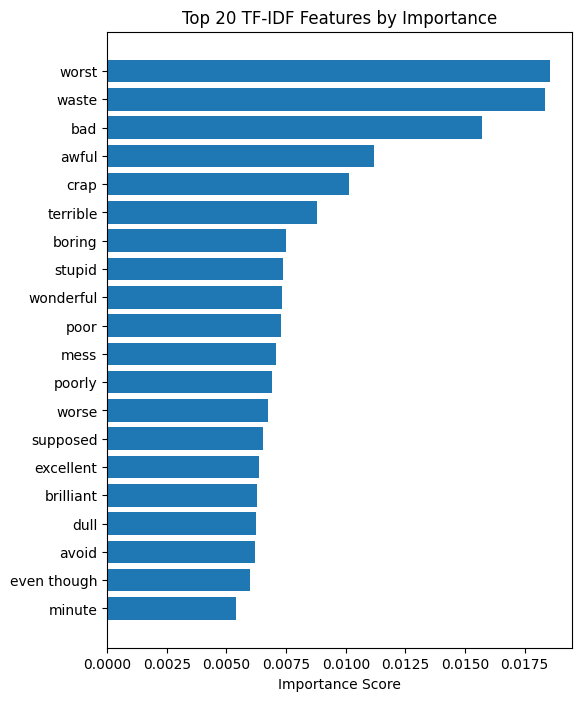

In [30]:
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]
features = np.array(tfidf.get_feature_names_out())[indices]
plt.figure(figsize=(6,8))
plt.barh(features, importances[indices])
plt.title('Top 20 TF‑IDF Features by Importance')
plt.xlabel('Importance Score')
plt.show()

## 7. **Comparison with Other Algorithms**

**Logistic Regression**

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)
y_lr = lr.predict(xtest)
print(classification_report(ytest, y_lr))

y_prob = lr.predict_proba(xtest)[:,1]
lr_roc_auc = roc_auc_score(ytest, y_prob)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**LinearSVC**

In [32]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()
LSVC.fit(xtrain, ytrain)
y_svc = LSVC.predict(xtest)
print("Classification Report: \n", classification_report(ytest, y_svc))

y_prob = LSVC.decision_function(xtest)
lsvc_roc_auc = roc_auc_score(ytest, y_prob)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      4961
           1       0.90      0.91      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**Comparison**

In [33]:
results = {
    'Model': ['XGBoost', 'LogisticRegression', 'LinearSVC'],
    'Accuracy': [
        accuracy_score(ytest, predictions),
        accuracy_score(ytest, y_lr),
        accuracy_score(ytest, y_svc)
    ],
    'Precision': [
        precision_score(ytest, predictions),
        precision_score(ytest, y_lr),
        precision_score(ytest, y_svc)
    ],
    'Recall': [
        recall_score(ytest, predictions),
        recall_score(ytest, y_lr),
        recall_score(ytest, y_svc)
    ],
    'F1 Score': [
        f1_score(ytest, predictions),
        f1_score(ytest, y_lr),
        f1_score(ytest, y_svc)
    ],
    'AUC': [
        xgb_roc_auc,
        lr_roc_auc,
        lsvc_roc_auc
    ]
}

metrics_df = pd.DataFrame(results)
metrics_df[['Accuracy','Precision','Recall','F1 Score', 'AUC']] = metrics_df[['Accuracy','Precision','Recall','F1 Score', 'AUC']].round(4)
print(metrics_df)


                Model  Accuracy  Precision  Recall  F1 Score     AUC
0             XGBoost    0.8618     0.8516  0.8789    0.8650  0.9396
1  LogisticRegression    0.8997     0.8896  0.9145    0.9018  0.9654
2           LinearSVC    0.9087     0.9050  0.9149    0.9099  0.9688


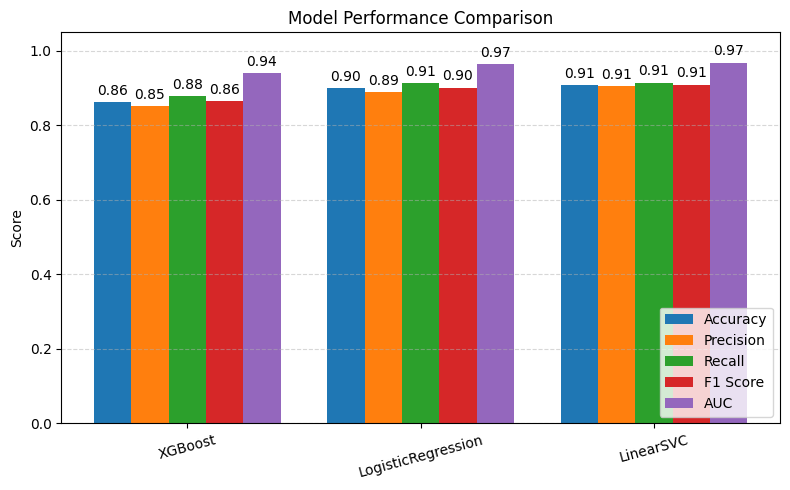

In [34]:
models = metrics_df['Model']
scores = metrics_df.set_index('Model')[['Accuracy','Precision','Recall','F1 Score','AUC']]

x = np.arange(len(models))
n_metrics = len(scores.columns)
width = 0.8 / n_metrics

fig, ax = plt.subplots(figsize=(8, 5))

for i, metric in enumerate(scores.columns):
    offset = (i - (n_metrics - 1) / 2) * width
    rects = ax.bar(x + offset, scores[metric], width, label=metric)
    ax.bar_label(rects, fmt='%.2f', padding=3)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)

ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 8. **Conclusion**

In this project, I built a sentiment classification pipeline for the IMDB 50,000-review dataset using XGBoost and benchmarked it against two classical baselines (Logistic Regression and Linear SVC). My key findings are:


*  **Data Characteristics & EDA**  
      - The dataset is perfectly balanced (50% positive, 50% negative).  
      - Review lengths vary widely (17–21,500 characters), and negative reviews tend to be slightly longer on average.  
      - Common words like “film,” “movie,” and sentiment-laden adjectives (“great,” “bad”) dominate.


*  **Preprocessing & Feature Engineering**  
      - Cleaning (HTML tag removal, lemmatization, stopword filtering) reduced noise and vocabulary size.  
      - TF-IDF vectorization with unigrams + bigrams (max_features=50,000) captured both word-level and phrase-level sentiment signals.


*  **Model Performance**  
      - **XGBoost** achieved a validation accuracy of **≈86%**, but Logistic Regression (≈90%) and Linear SVC (≈91%) outperformed it across all metrics (precision, recall, F1-score).  
